Cell 1: Imports and Setup

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import os

# Color map for job annotations on plots
JOB_COLOR_MAP = {
    "parsec-blackscholes": "darkgoldenrod", # Adjusted to be a bit darker like example
    "parsec-canneal": "tan",
    "parsec-dedup": "plum",
    "parsec-ferret": "powderblue", # Adjusted for lighter shade
    "parsec-freqmine": "limegreen",
    "parsec-radix": "darkturquoise",
    "parsec-vips": "red",
    "memcached": "dodgerblue", # Color for memcached
}

# Job names for the summary table (short versions)
TABLE_DISPLAY_JOB_NAMES = ["blackscholes", "canneal", "dedup", "ferret", "freqmine", "radix", "vips"]

# Number of runs to process
NUM_RUNS = 3

Cell 2: Parsing Functions

In [6]:
def parse_time_str(time_str):
    """Converts a time string (H:M:S, M:S, or S) to total seconds."""
    parts = list(map(int, time_str.split(':')))
    if len(parts) == 3:  # H:M:S
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    elif len(parts) == 2:  # M:S
        return parts[0] * 60 + parts[1]
    elif len(parts) == 1:  # S
        return parts[0]
    raise ValueError(f"Invalid time string format: {time_str}")

def parse_makespan_file(filepath):
    """Parses a makespan_X.txt file to extract execution times for parsec jobs."""
    job_times = {}
    current_job_name = None
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                if line.startswith("Job:"):
                    current_job_name = line.split("Job:", 1)[1].strip()
                elif line.startswith("Job time:") and current_job_name:
                    time_str = line.split("Job time:", 1)[1].strip()
                    if current_job_name.startswith("parsec-"):
                        job_times[current_job_name] = parse_time_str(time_str)
                    current_job_name = None
    except FileNotFoundError:
        print(f"Error: Makespan file not found: {filepath}")
        return {}
    return job_times

def parse_mcperf_file(filepath):
    """Parses a mcperf_X.txt file and returns a DataFrame with p95 latency and timestamps."""
    try:
        header_line_num = 0
        with open(filepath, 'r') as f:
            for i, line_content in enumerate(f):
                if line_content.startswith("#type"):
                    header_line_num = i
                    break
        df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)
        if '#type' in df.columns:
            df = df[df['#type'] == 'read'].copy()
        else:
            print(f"Warning: '#type' column not found in {filepath}. Assuming all rows are 'read' operations.")
            df = df.copy()
        if 'p95' in df.columns:
            df['p95_ms'] = df['p95'] / 1000.0
        else:
            df['p95_ms'] = np.nan
            print(f"Warning: 'p95' column not found in {filepath}.")
        for col in ['ts_start', 'ts_end', 'p95_ms']:
            if col not in df.columns:
                df[col] = np.nan
                print(f"Warning: Column '{col}' not found in {filepath}. Plotting might be affected.")
        return df[['ts_start', 'ts_end', 'p95_ms']]
    except FileNotFoundError:
        print(f"Error: mcperf file not found: {filepath}")
        return pd.DataFrame(columns=['ts_start', 'ts_end', 'p95_ms'])
    except pd.errors.EmptyDataError:
        print(f"Error: mcperf file is empty or unparseable: {filepath}")
        return pd.DataFrame(columns=['ts_start', 'ts_end', 'p95_ms'])

def parse_pods_file(filepath):
    """
    Parses a pods_X.json file to extract start/end times of batch job containers
    and start time/node of the memcached container.
    Returns batch job timings, memcached info, and the earliest start time among them.
    """
    batch_job_timings = []
    memcached_info = None # Will store {'node_name': ..., 'start_epoch': ..., 'name': 'memcached'}
    
    # Use min_start_epoch_overall to track the true earliest start for x=0 alignment
    min_start_epoch_overall = float('inf')

    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Pods file not found: {filepath}")
        return [], None, None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {filepath}")
        return [], None, None

    for pod in data.get('items', []):
        metadata = pod.get('metadata', {})
        labels = metadata.get('labels', {})
        job_name_label = labels.get('job-name')       # For batch jobs (e.g., parsec-blackscholes)
        pod_name_from_label = labels.get('name')      # For memcached (e.g., "some-memcached")
        node_name = pod.get('spec', {}).get('nodeName')
        status = pod.get('status', {})

        # Identify batch jobs (parsec)
        if job_name_label and "parsec-" in job_name_label:
            if status.get('containerStatuses'):
                for c_status in status['containerStatuses']:
                    if c_status.get('state', {}).get('terminated'):
                        terminated_state = c_status['state']['terminated']
                        started_at_str = terminated_state.get('startedAt')
                        finished_at_str = terminated_state.get('finishedAt')
                        
                        if not started_at_str or not finished_at_str or not node_name:
                            print(f"Warning: Missing data for batch job container in pod {metadata.get('name', 'N/A')} in {filepath}")
                            continue
                        try:
                            started_dt = datetime.strptime(started_at_str, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
                            finished_dt = datetime.strptime(finished_at_str, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
                            started_epoch = started_dt.timestamp()
                            finished_epoch = finished_dt.timestamp()
                            
                            batch_job_timings.append({
                                'job_name': job_name_label,
                                'start_epoch': started_epoch,
                                'end_epoch': finished_epoch,
                                'node_name': node_name
                            })
                            if started_epoch < min_start_epoch_overall:
                                min_start_epoch_overall = started_epoch
                        except ValueError as e:
                            print(f"Warning: Error parsing time for batch job {job_name_label} in {filepath}: {e}")
        
        # Identify memcached pod by its 'name' label
        elif pod_name_from_label == "some-memcached": # Assuming 'name: some-memcached' is the label
            started_at_str_memcached = None
            # Memcached is long-running, check 'running' state primarily
            if status.get('containerStatuses'):
                c_status_memcached = status['containerStatuses'][0] # Assuming one container
                if c_status_memcached.get('state', {}).get('running'):
                    started_at_str_memcached = c_status_memcached['state']['running'].get('startedAt')
                # Fallback if it was running and then its state was captured in lastState (less likely for active run)
                elif c_status_memcached.get('lastState', {}).get('running'):
                     started_at_str_memcached = c_status_memcached['lastState']['running'].get('startedAt')
            
            # Fallback to pod's overall startTime if container-specific running startTime isn't found
            if not started_at_str_memcached:
                 started_at_str_memcached = status.get('startTime')

            if started_at_str_memcached and node_name:
                try:
                    started_dt_memcached = datetime.strptime(started_at_str_memcached, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
                    memcached_start_epoch = started_dt_memcached.timestamp()
                    memcached_info = {
                        'node_name': node_name,
                        'start_epoch': memcached_start_epoch,
                        'name': 'memcached' # Consistent name for plotting
                    }
                    if memcached_start_epoch < min_start_epoch_overall:
                        min_start_epoch_overall = memcached_start_epoch
                except ValueError as e:
                    print(f"Warning: Error parsing memcached start time {started_at_str_memcached} in {filepath}: {e}")

    # If min_start_epoch_overall is still infinity, no relevant pods were found or successfully parsed
    # The first container start time for x=0 alignment is min_start_epoch_overall if found.
    # The prompt for Part 3 stated: "Align the x axis so that x = 0 coincides with the starting time of the first batch-job-container"
    # However, the example plot includes memcached from time 0 if it's the earliest.
    # For robust plotting, min_start_epoch_overall should be the earliest of ANY plotted entity.
    # The current logic for min_start_epoch_overall achieves this.

    return batch_job_timings, memcached_info, min_start_epoch_overall if min_start_epoch_overall != float('inf') else None

Cell 3: Load Data and Generate Summary Table

In [11]:
# --- Data Loading and Table Generation ---

# Store individual job times across runs
# Key: short_job_name (e.g., "blackscholes"), Value: list of times from 3 runs
job_times_collected = {name: [] for name in TABLE_DISPLAY_JOB_NAMES}
# Store makespan for each run (calculated from pod data)
makespans_collected = []

for i in range(1, NUM_RUNS + 1):
    makespan_filepath_run = f"makespan_{i}.txt"
    pods_filepath_run = f"pods_{i}.json"
    
    # 1. Get individual job times from makespan file
    run_job_times_data = parse_makespan_file(makespan_filepath_run)
    for job_fullname, time_val in run_job_times_data.items():
        # job_fullname is "parsec-blackscholes", etc.
        short_name = job_fullname.replace("parsec-", "")
        if short_name in job_times_collected:
             job_times_collected[short_name].append(time_val)
    
    # 2. Calculate makespan for this run from pod data
    batch_job_timings_list_run, memcached_info_run, run_overall_start_epoch = parse_pods_file(pods_filepath_run)
    if batch_job_timings_list_run and run_overall_start_epoch is not None: 
        run_max_end_epoch = max(p['end_epoch'] for p in batch_job_timings_list_run)
        run_min_batch_start = min(p['start_epoch'] for p in batch_job_timings_list_run)
        run_makespan_val = run_max_end_epoch - run_min_batch_start

        makespans_collected.append(run_makespan_val)
    else:
        # If pod data is missing or incomplete, record makespan as NaN for this run
        makespans_collected.append(np.nan)
        print(f"Warning: Could not calculate makespan for run {i} due to missing pod data.")

# --- Calculate Mean and Standard Deviation for the Table ---
table_output_rows = []

# For parsec jobs
for short_job_name in TABLE_DISPLAY_JOB_NAMES:
    times = job_times_collected[short_job_name]
    
    # Ensure we have data from all runs for a consistent calculation
    # If a job's data is missing for a run, its mean/std might be misleading or NaN
    mean_val = np.mean(times) if len(times) == NUM_RUNS and not np.isnan(times).any() else np.nan
    std_val = np.std(times) if len(times) == NUM_RUNS and not np.isnan(times).any() else np.nan
    
    table_output_rows.append({
        "job name": short_job_name,
        "mean time [s]": f"{mean_val:.2f}" if not np.isnan(mean_val) else "N/A",
        "std [s]": f"{std_val:.2f}" if not np.isnan(std_val) else "N/A"
    })

# For "total time" (makespan)
mean_makespan_val = np.nanmean(makespans_collected) if len(makespans_collected) == NUM_RUNS else np.nan
std_makespan_val = np.nanstd(makespans_collected) if len(makespans_collected) == NUM_RUNS else np.nan

table_output_rows.append({
    "job name": "total time",
    "mean time [s]": f"{mean_makespan_val:.2f}" if not np.isnan(mean_makespan_val) else "N/A",
    "std [s]": f"{std_makespan_val:.2f}" if not np.isnan(std_makespan_val) else "N/A"
})

summary_table_df = pd.DataFrame(table_output_rows)

print("--- Job Execution Time Summary ---")
print(summary_table_df.to_string(index=False))

--- Job Execution Time Summary ---
    job name mean time [s] std [s]
blackscholes         87.67    0.47
     canneal        189.67    0.94
       dedup         37.33    0.47
      ferret        155.33    0.47
    freqmine        154.00    0.00
       radix         23.33    0.47
        vips         82.00    0.82
  total time        190.33    1.25


Cell 4: SLO Violation Calculation

In [8]:
print("\n--- Memcached SLO Violation Ratios ---")
slo_violation_ratios_all_runs = []

for i in range(1, NUM_RUNS + 1):
    mcperf_filepath_run = f"mcperf_{i}.txt"
    pods_filepath_run = f"pods_{i}.json"
    
    mcperf_data_run = parse_mcperf_file(mcperf_filepath_run)
    batch_job_timings_list_run, memcached_info_run, run_overall_start_epoch = parse_pods_file(pods_filepath_run)
    
    if not batch_job_timings_list_run:
        print(f"Run {i}: No batch job timings found. Cannot calculate SLO violation ratio.")
        slo_violation_ratios_all_runs.append(np.nan)
        continue
    
    if mcperf_data_run.empty or mcperf_data_run['ts_start'].isnull().all():
        print(f"Run {i}: No valid mcperf data. Cannot calculate SLO violation ratio.")
        slo_violation_ratios_all_runs.append(np.nan)
        continue
        
    # Determine the time window for batch job execution
    first_batch_job_start_epoch = min(p['start_epoch'] for p in batch_job_timings_list_run)
    last_batch_job_end_epoch = max(p['end_epoch'] for p in batch_job_timings_list_run)
    
    # Filter mcperf data points whose collection interval [ts_start, ts_end] overlaps
    # with the batch job execution window [first_batch_job_start_epoch, last_batch_job_end_epoch].
    # For simplicity, we consider mcperf samples whose 'ts_start' falls within the window.
    # ts_start from mcperf is in milliseconds.
    
    relevant_mcperf_samples = mcperf_data_run[
        (mcperf_data_run['ts_start'] >= first_batch_job_start_epoch * 1000) &
        (mcperf_data_run['ts_start'] < last_batch_job_end_epoch * 1000) # ts_start is beginning of interval
    ]
    
    if relevant_mcperf_samples.empty:
        print(f"Run {i}: No mcperf data points fall within the batch job execution window.")
        # If there are no points in the window, the violation count is 0.
        # If the denominator (total_points_in_window) is 0, ratio is typically 0 or undefined.
        # Let's define it as 0 if no relevant points.
        slo_violation_ratios_all_runs.append(0.0) 
        print(f"Run {i}: 0/0 = 0.0000")
        continue

    total_points_in_window = len(relevant_mcperf_samples)
    # p95_ms > 1.0 ms (SLO: 95th percentile latency > 1ms)
    violation_points = len(relevant_mcperf_samples[relevant_mcperf_samples['p95_ms'] > 1.0])
    
    ratio = violation_points / total_points_in_window if total_points_in_window > 0 else 0.0
    slo_violation_ratios_all_runs.append(ratio)
    print(f"Run {i}: {violation_points}/{total_points_in_window} = {ratio:.4f}")

# Optionally, print mean/std of SLO ratios if needed
# print(f"\nMean SLO Violation Ratio over {NUM_RUNS} runs: {np.nanmean(slo_violation_ratios_all_runs):.4f}")
# print(f"Std Dev SLO Violation Ratio over {NUM_RUNS} runs: {np.nanstd(slo_violation_ratios_all_runs):.4f}")


--- Memcached SLO Violation Ratios ---
Run 1: 0/17 = 0.0000
Run 2: 0/16 = 0.0000
Run 3: 0/16 = 0.0000


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)
/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)
/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)


Cell 5: Plotting Function Definition

In [9]:
def create_latency_plot_v2(run_idx, mcperf_df_plot, batch_job_timings_plot, memcached_info_plot, overall_run_start_epoch):
    """Creates a multi-subplot plot: latency on top, job timelines per node below."""

    if overall_run_start_epoch is None:
        print(f"Run {run_idx}: Overall start epoch is None, cannot generate plot.")
        return

    # --- Determine unique nodes and overall X-axis limit ---
    node_names_from_batch = set()
    if batch_job_timings_plot:
        node_names_from_batch = set(p['node_name'] for p in batch_job_timings_plot)
    
    all_node_names = list(node_names_from_batch)
    if memcached_info_plot and memcached_info_plot['node_name'] not in node_names_from_batch:
        all_node_names.append(memcached_info_plot['node_name'])
    
    unique_node_names = sorted(list(set(all_node_names))) # Ensure uniqueness and sort
    num_node_subplots = len(unique_node_names)

    if num_node_subplots == 0 and mcperf_df_plot.empty : # No data to plot
        print(f"Run {run_idx}: No node data or mcperf data to plot.")
        return


    # Calculate common x-axis maximum limit (relative to overall_run_start_epoch)
    max_rel_end_time_batch = 0
    if batch_job_timings_plot:
        valid_batch_ends = [job['end_epoch'] for job in batch_job_timings_plot if 'end_epoch' in job]
        if valid_batch_ends:
             max_rel_end_time_batch = max(valid_batch_ends) - overall_run_start_epoch
        else: # Handle case where no batch jobs have end_epoch (should not happen for completed jobs)
            max_rel_end_time_batch = 0


    max_rel_end_time_mcperf = 0
    if not mcperf_df_plot.empty and 'ts_end' in mcperf_df_plot.columns:
        valid_mcperf_ends = mcperf_df_plot['ts_end'].dropna()
        if not valid_mcperf_ends.empty:
            max_rel_end_time_mcperf = (valid_mcperf_ends.max() / 1000.0) - overall_run_start_epoch
    
    common_x_max = max(max_rel_end_time_batch, max_rel_end_time_mcperf, 10.0) # Ensure a minimum width (e.g. 10s)

    # --- Create Subplots ---
    # Adjust height ratios: latency plot taller.
    # If no node subplots, num_node_subplots will be 0
    num_total_subplots = 1 + num_node_subplots if num_node_subplots > 0 else 1
    
    height_ratios = []
    if num_node_subplots > 0:
        height_ratios = [2] + [1] * num_node_subplots # Latency plot 2x height of node plots
    else: # Only latency plot
        height_ratios = [1]


    fig, axes = plt.subplots(
        nrows=num_total_subplots, 
        ncols=1, 
        figsize=(9, 2.5 * height_ratios[0] + (num_node_subplots * 1.8) ), # Adjusted figsize logic
        sharex=True, 
        gridspec_kw={'height_ratios': height_ratios} if num_node_subplots > 0 else None
    )

    # If only one subplot (e.g. only latency or only one node if logic changes), axes is not a list
    if num_total_subplots == 1:
        axes = [axes] 

    ax_latency = axes[0]

    # --- 1. Plot 95th Percentile Latency (Top Subplot) ---
    ax_latency.set_title(f"95th percentile latency over time (Run {run_idx})", fontsize=11)
    ax_latency.set_ylabel("95th Percentile Latency (ms)", fontsize=9)

    if not mcperf_df_plot.empty:
        bar_start_times_rel = (mcperf_df_plot['ts_start'] / 1000.0) - overall_run_start_epoch
        bar_widths_val = (mcperf_df_plot['ts_end'] - mcperf_df_plot['ts_start']) / 1000.0
        p95_latencies_val = mcperf_df_plot['p95_ms']
        
        valid_bars = ~np.isnan(bar_start_times_rel) & ~np.isnan(bar_widths_val) & \
                     ~np.isnan(p95_latencies_val) & (bar_widths_val > 0)
        
        ax_latency.bar(bar_start_times_rel[valid_bars], 
                       p95_latencies_val[valid_bars], 
                       width=bar_widths_val[valid_bars], 
                       align='edge', color='steelblue', alpha=0.7, edgecolor='darkblue', linewidth=0.5)
    
    ax_latency.axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.8)
    # Position text relative to axis limits. Ensure y_lim is set before placing text.
    max_latency_val = np.nanmax(mcperf_df_plot['p95_ms']) if not mcperf_df_plot.empty and mcperf_df_plot['p95_ms'].notna().any() else 1.2
    ax_latency.set_ylim(0, max(1.2, max_latency_val * 1.1)) # Ensure SLO line is visible
    
    # Place "SLO Objective" text. Check if common_x_max is valid.
    text_x_pos = common_x_max * 0.98 if common_x_max > 0 else 0.98 # Default if common_x_max is 0
    ax_latency.text(text_x_pos, 1.03, 'SLO Objective', color='black', ha='right', va='bottom', fontsize=8)
    
    ax_latency.grid(True, linestyle=':', alpha=0.6)
    ax_latency.tick_params(axis='both', which='major', labelsize=8)


    # --- 2. Plot Job Timelines (Per Node Subplots) ---
    if num_node_subplots > 0:
        for i, node_name_iter in enumerate(unique_node_names):
            ax_node = axes[i + 1]
            ax_node.set_title(f"{node_name_iter} (Run {run_idx})", fontsize=10, y=0.98) # y to prevent overlap if title is long

            jobs_on_this_node_for_plot = []

            # Add memcached if it ran on this node
            if memcached_info_plot and memcached_info_plot['node_name'] == node_name_iter:
                start_rel = memcached_info_plot['start_epoch'] - overall_run_start_epoch
                # Memcached bar extends to the end of the common_x_max
                jobs_on_this_node_for_plot.append({
                    'name': 'memcached', # Short name
                    'start_rel': start_rel,
                    'end_rel': common_x_max, 
                    'color': JOB_COLOR_MAP.get('memcached', 'grey'),
                    'original_start_epoch': memcached_info_plot['start_epoch']
                })

            # Add batch jobs that ran on this node
            if batch_job_timings_plot:
                for job_details in batch_job_timings_plot:
                    if job_details['node_name'] == node_name_iter:
                        job_short_name = job_details['job_name'].replace("parsec-", "")
                        start_rel = job_details['start_epoch'] - overall_run_start_epoch
                        end_rel = job_details['end_epoch'] - overall_run_start_epoch
                        jobs_on_this_node_for_plot.append({
                            'name': job_short_name,
                            'start_rel': start_rel,
                            'end_rel': end_rel,
                            'color': JOB_COLOR_MAP.get(job_details['job_name'], 'grey'), # Use full name for color map
                            'original_start_epoch': job_details['start_epoch']
                        })
            
            # Sort jobs: example order seems specific. Let's try by start time, then name.
            # The image seems to have memcached at top, then others by start time.
            # If memcached is present, make it first in y_order, then sort others.
            
            memcached_entry = next((j for j in jobs_on_this_node_for_plot if j['name'] == 'memcached'), None)
            other_jobs = [j for j in jobs_on_this_node_for_plot if j['name'] != 'memcached']
            other_jobs.sort(key=lambda x: (x['original_start_epoch'], x['name']))
            
            sorted_jobs_for_y_axis = []
            if memcached_entry:
                sorted_jobs_for_y_axis.append(memcached_entry)
            sorted_jobs_for_y_axis.extend(other_jobs)


            y_job_names_display = [job['name'] for job in sorted_jobs_for_y_axis]

            for job_to_plot in sorted_jobs_for_y_axis:
                # Ensure start_rel is not negative for plotting width, clip at 0 for common x-axis
                plot_left = max(0, job_to_plot['start_rel'])
                plot_end = max(0, job_to_plot['end_rel'])
                width = plot_end - plot_left
                if width < 0: width = 0 # Should not happen if end_rel >= start_rel

                if width > 0 : # Only plot if there's a positive duration
                    ax_node.barh(job_to_plot['name'], width, left=plot_left, height=0.6,
                                 color=job_to_plot['color'], edgecolor='dimgray', linewidth=0.5, alpha=0.9)

            if y_job_names_display:
                ax_node.set_yticks(y_job_names_display)
                ax_node.invert_yaxis() # To match example (memcached at top if first)
            
            ax_node.grid(True, axis='x', linestyle=':', alpha=0.6)
            ax_node.tick_params(axis='both', which='major', labelsize=8)
            ax_node.set_ylabel("") # No y-label like "Job Name"

    # Set common X-axis properties for the last subplot
    axes[-1].set_xlabel("Time (s)", fontsize=9)
    axes[-1].set_xlim(0, common_x_max) # Set x-limit for all shared axes

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # rect to leave space for suptitle if added
    # plt.subplots_adjust(hspace=0.5) # Adjust vertical spacing if needed
    plt.show()

Cell 6: Generate and Display Plots


--- Generating Plots ---
Generating plot for Run 1...


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)


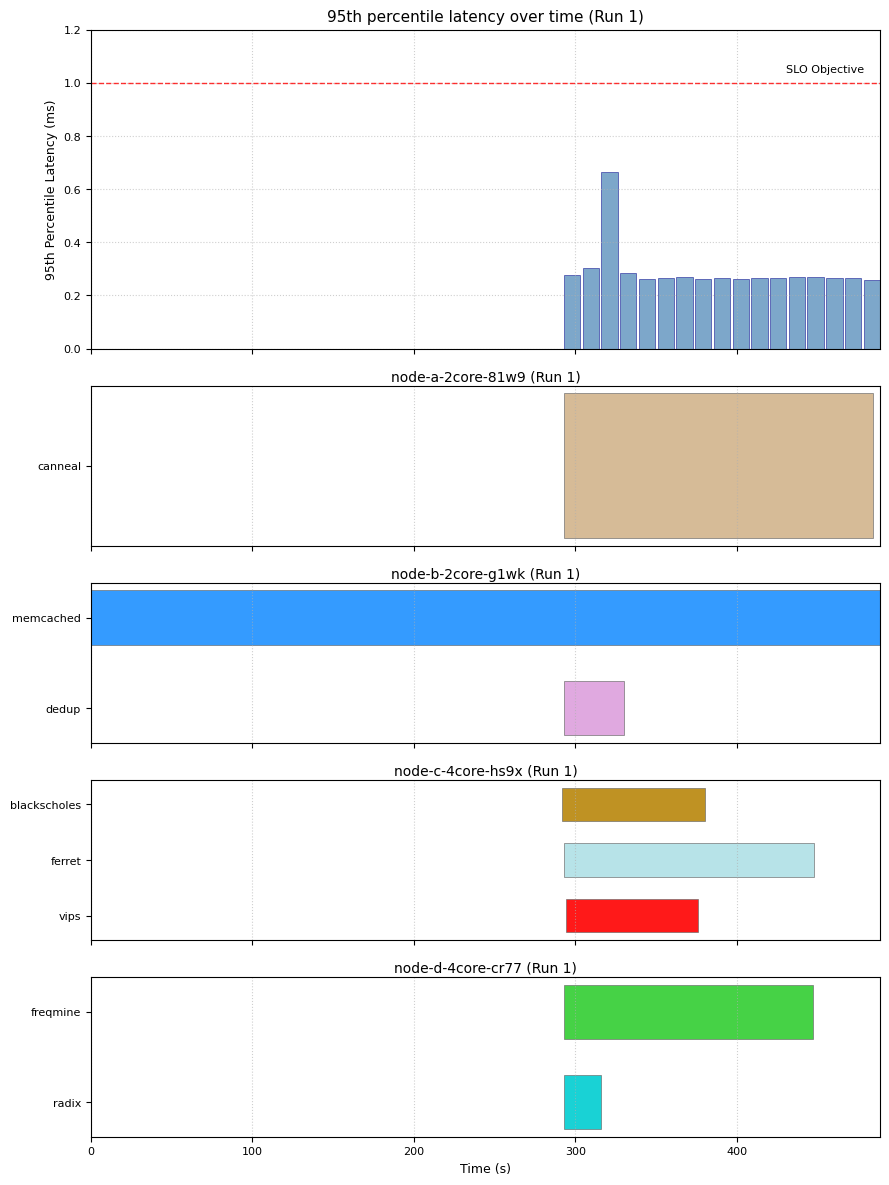

Generating plot for Run 2...


/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)


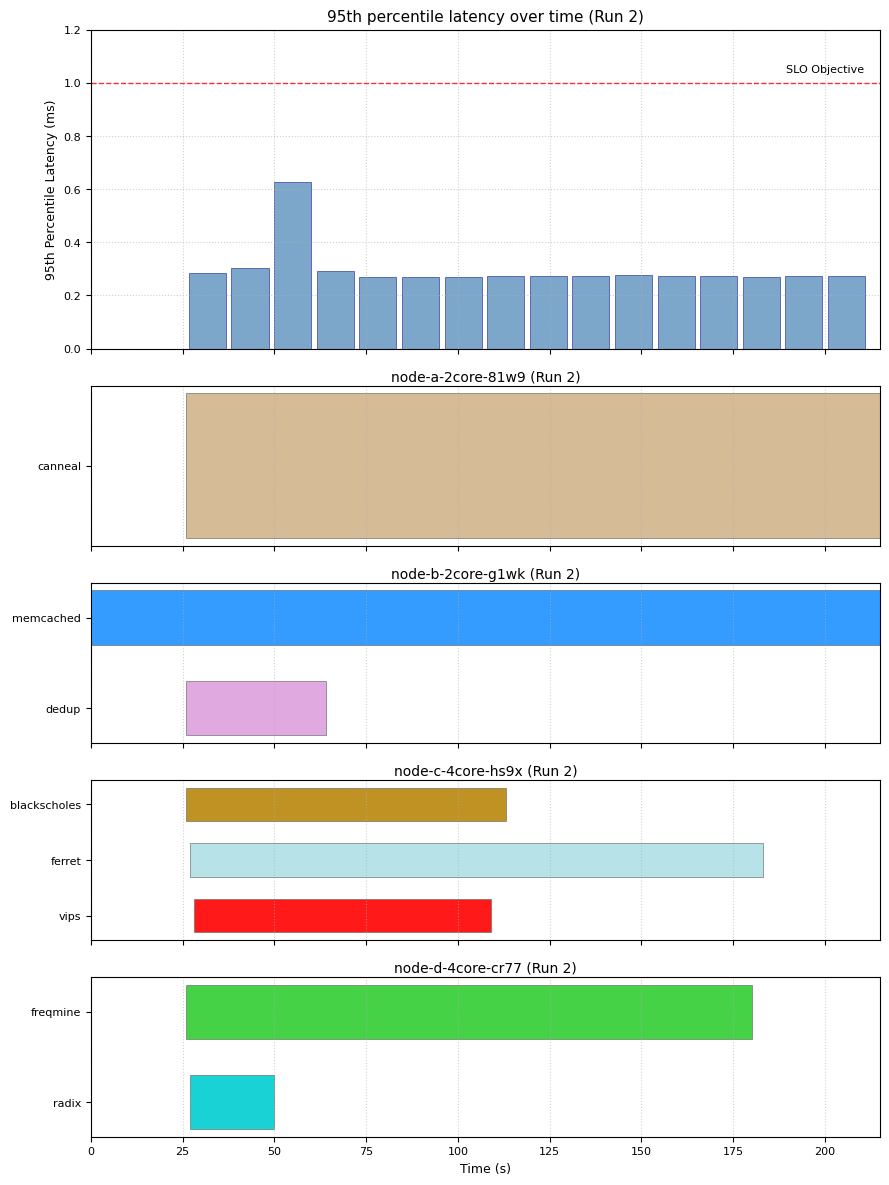

/var/folders/hf/7gmbm85d1ljgwd4ghvldyzqh0000gn/T/ipykernel_7835/2831047194.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, skiprows=header_line_num)


Generating plot for Run 3...


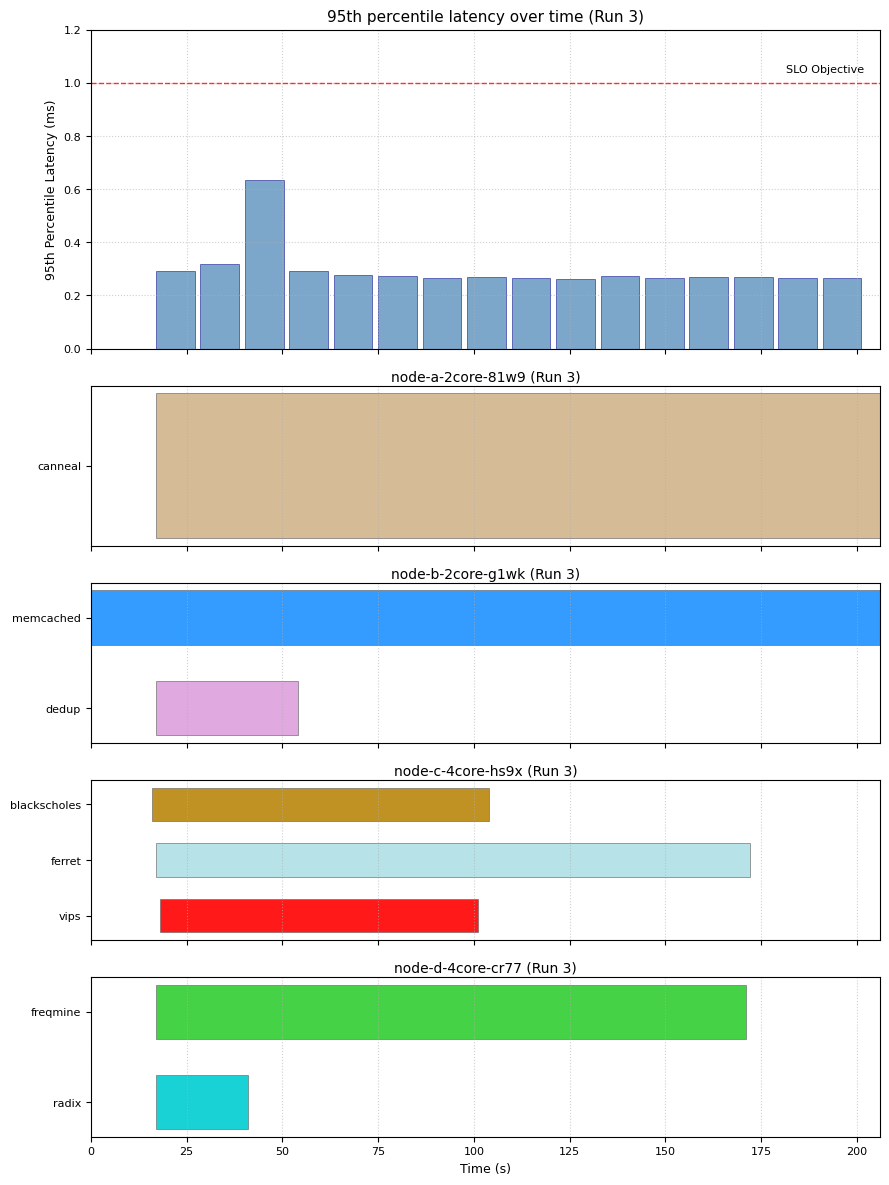

In [10]:
print("\n--- Generating Plots ---")
for i in range(1, NUM_RUNS + 1):
    mcperf_filepath_plot = f"mcperf_{i}.txt"
    pods_filepath_plot = f"pods_{i}.json"
    
    mcperf_data_for_plot = parse_mcperf_file(mcperf_filepath_plot)
    # Update to get all three return values
    batch_job_timings_for_plot, memcached_info_for_plot, run_overall_start_epoch_plot = parse_pods_file(pods_filepath_plot)
    
    if run_overall_start_epoch_plot is None:
        print(f"Plot for Run {i}: Could not determine overall start epoch. Skipping plot.")
        continue
    # Check if there's any data to plot for nodes, even if mcperf is empty
    has_node_data = bool(batch_job_timings_for_plot or memcached_info_for_plot)

    if mcperf_data_for_plot.empty and not has_node_data:
        print(f"Plot for Run {i}: No mcperf data and no job/node data to plot. Skipping plot.")
        continue
        
    print(f"Generating plot for Run {i}...")
    # Call the new plotting function
    create_latency_plot_v2(i, mcperf_data_for_plot, batch_job_timings_for_plot, memcached_info_for_plot, run_overall_start_epoch_plot)